In [3]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
from gensim.utils import lemmatize, simple_preprocess
import logging
import tempfile
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import re
%matplotlib inline
import sys
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
import itertools
import collections
import tweepy as tw
from nltk import bigrams
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import iplot
from textblob import TextBlob

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [4]:
datafile='gardenssingapore_tweet.csv'

In [5]:
import pandas as pd
tweets = pd.read_csv(datafile, encoding='utf-8')
tweets = tweets.assign(Time=pd.to_datetime(tweets.time))

print("Number of tweets: ",len(tweets['text']))
tweets.head(5)

Number of tweets:  2424


,text,time,user_name,Retweet_Count,Time
0,b'In Singapore: Two Cheers &amp; A Toast at Ga...,2019-11-24 00:27:02,b'audocs',0,2019-11-24 00:27:02
1,"b'Last event of the year, Singapore never grow...",2019-11-23 21:55:08,b'rochfrey',0,2019-11-23 21:55:08
2,b'#Singapore Diaries: Day 3 \xe2\x80\x93 Sento...,2019-11-23 17:40:39,b'FDTraveller',0,2019-11-23 17:40:39
3,b'Singapore Day 1 \xf0\x9f\x87\xb8\xf0\x9f\x87...,2019-11-23 14:51:11,b'mitrachaerin',0,2019-11-23 14:51:11
4,b'Gardens by The Bay Light Show\n\n#gopromax #...,2019-11-23 13:40:48,b'ROBERTWORX',0,2019-11-23 13:40:48


In [6]:
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity',
    height=450,
    width=1200,
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [31]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

stop_words = set(stopwords.words('english'))
stop_words.update(('singapore','gardens','bay','jewel','look','saw','im','changiairport','jewelchangiairport','like','see','got','go','use','taking','take'))

def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = tweet[1:]
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', '', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    #tweet= TextBlob(tweet).correct()
    words = tweet.split()
    use_stemmer = False
    porter_stemmer = PorterStemmer()
    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)
    #example_sent = "This is a sample sentence, showing off the stop words filtration."
  
    #stop_words.extend('singapore','jbkjbbk')
  
    #word_tokens = word_tokenize(processed_tweet) 
  
    filtered_sentence = [w for w in processed_tweet if not w in stop_words] 
  
    filtered_sentence = [] 
  
    for w in processed_tweet: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return ' '.join(filtered_sentence)

tweets['clean_tweet'] = tweets.text.apply(preprocess_tweet)

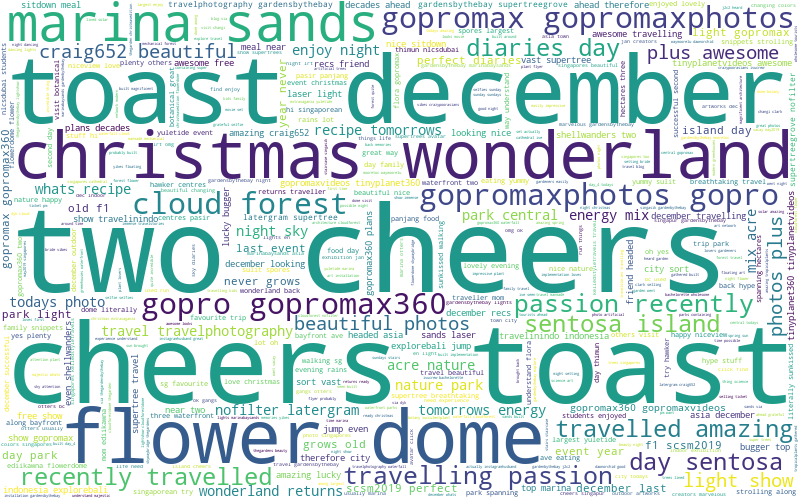

In [32]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(tweets['clean_tweet'].values))# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500,background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

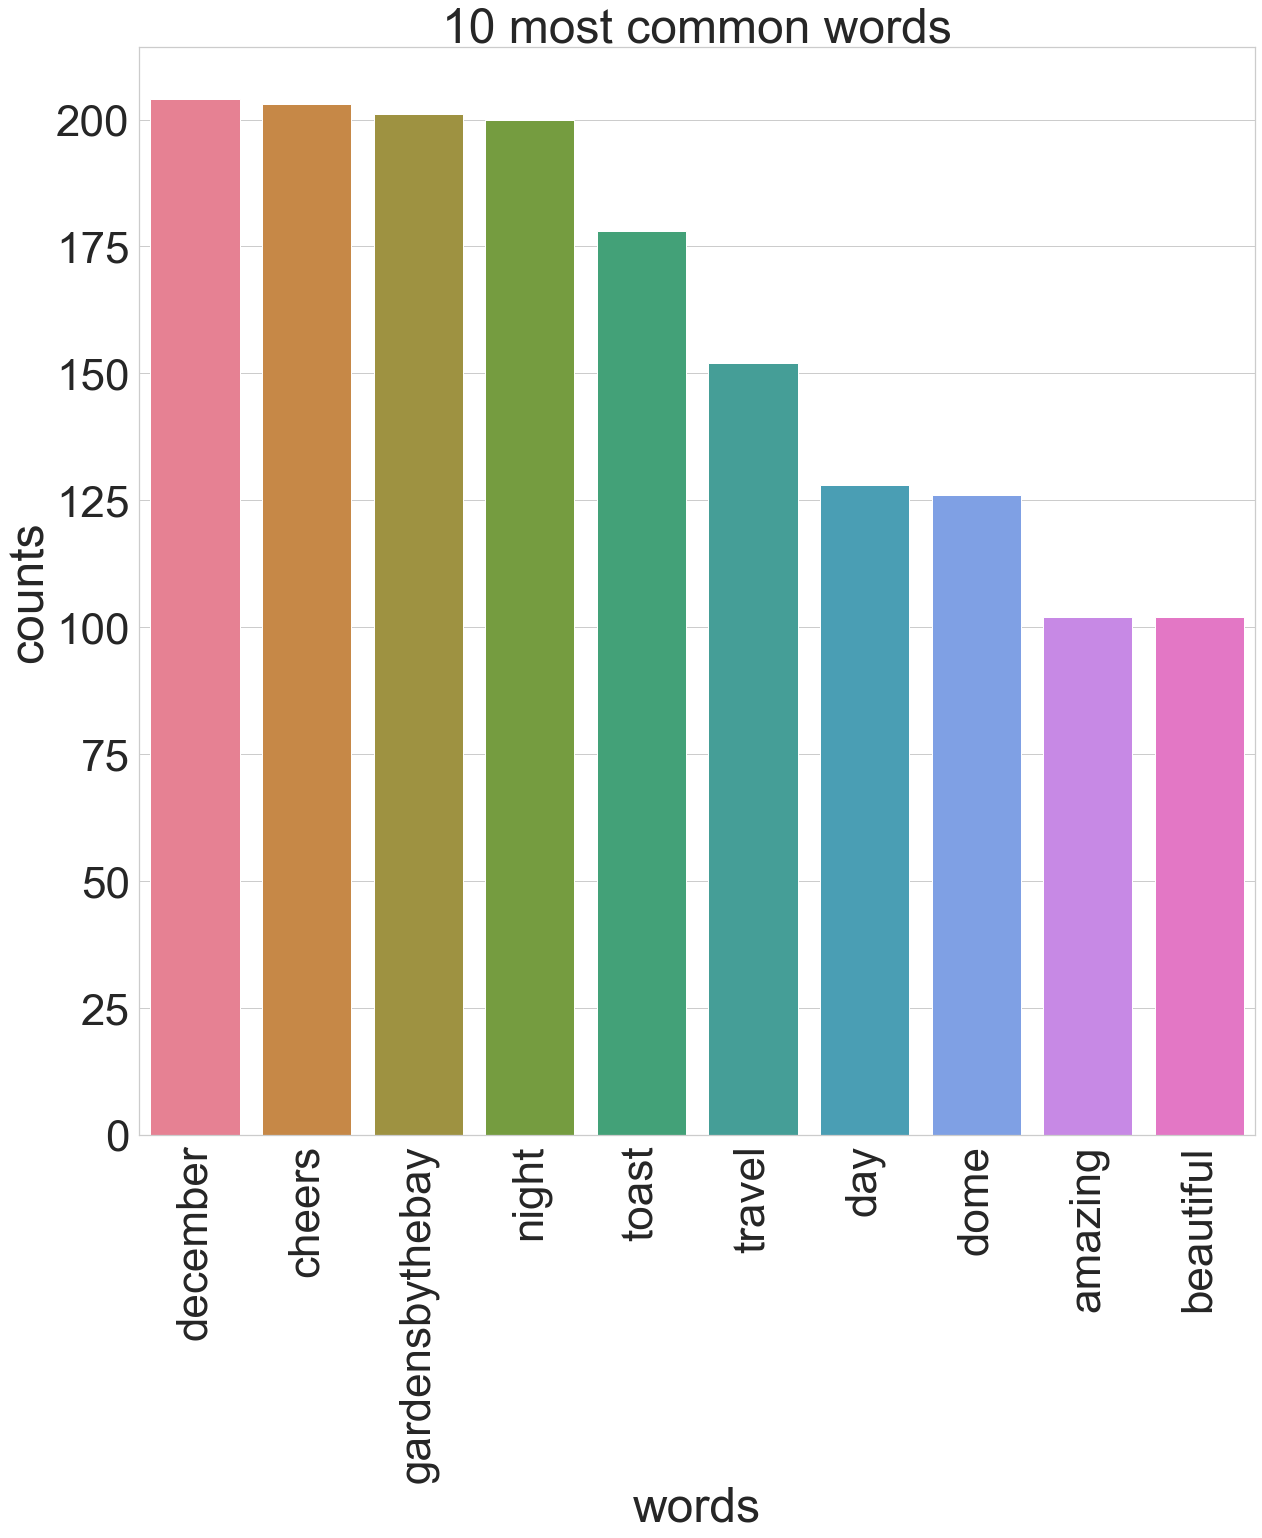

In [33]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as npimport 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(20, 20))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=4, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tweets['clean_tweet'])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [34]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 4), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(tweets['clean_tweet'], 20)
mydict={}
for word, freq in common_words:
    print(word,freq)
    bigram_df  = pd.DataFrame(common_words, columns = ['ngram' , 'count'])
bigram_df.groupby('ngram').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

cheers toast 178
toast december 178
cheers toast december 178
flower dome 101
christmas wonderland 77
marina sands 76
gopromax gopromaxphotos 76
gopromaxphotos gopro 76
gopro gopromax360 76
gopromax gopromaxphotos gopro 76
gopromaxphotos gopro gopromax360 76
gopromax gopromaxphotos gopro gopromax360 76
cloud forest 75
travelling passion 52
passion recently 52
recently travelled 52
travelled amazing 52
travelling passion recently 52
passion recently travelled 52
recently travelled amazing 52


[nltk_data] Downloading package stopwords to C:\Users\Oishee
[nltk_data]     Bhattacharyya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Oishee Bhattacharyya\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



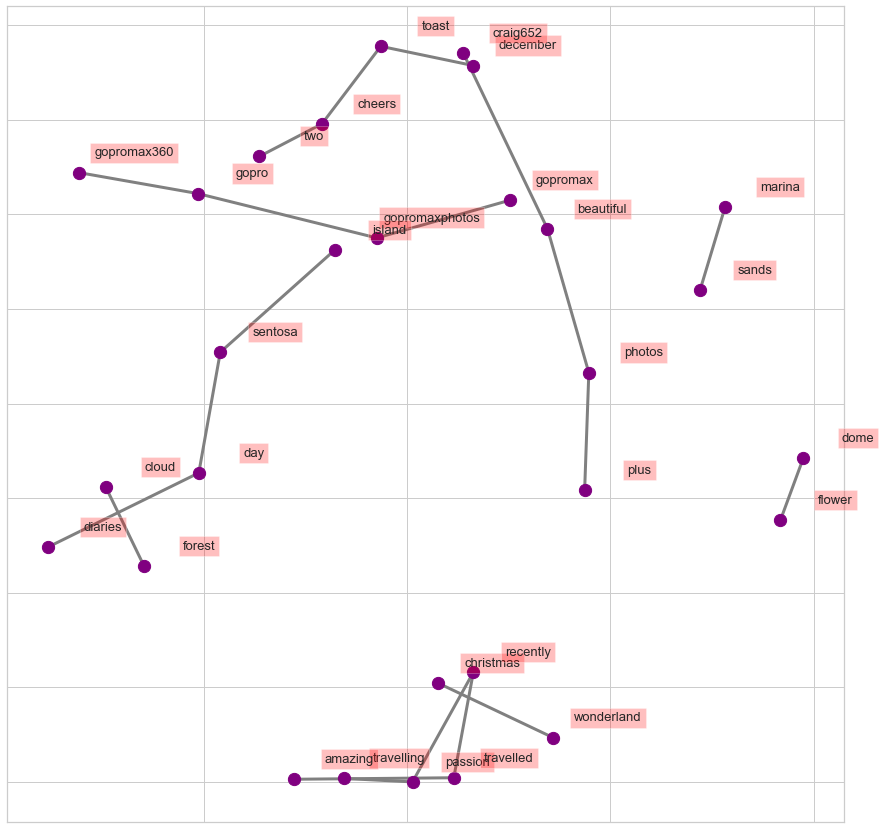

In [35]:
words_in_tweet= [tweet.lower().split() for tweet in tweets.clean_tweet]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
#tweets_nsw = [[word for word in tweet_words if not word in stop_words] for tweet_words in words_in_tweet]

tweets_nsw=words_in_tweet
collection_words = ['experience', 'new']

tweets_nsw_nc = [[w for w in word if not w in collection_words] for word in tweets_nsw]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_nc]
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)
bigram_dff = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_dff

# Create dictionary of bigrams and their counts
d = bigram_dff.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

#G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(15, 15))

pos = nx.spring_layout(G, k=5)
#pos = nx.nx_pydot.pydot_layout(G, prog='dot')
#pos = nx.fruchterman_reingold_layout(G, k=10, scale=50, seed=101)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=15,
                 width=3,
                 node_size=150,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    #x, y = value[0]+1, value[1]+2
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [36]:
data = tweets.clean_tweet.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['two', 'cheers', 'toast', 'december']]


Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [37]:
# Build the bigram and trigram models
from gensim.models import Phrases
from gensim.models.phrases import Phraser 

phrases = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(phrases)
trigram_mod = Phrases(bigram_mod[data_words])

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['two', 'cheers', 'toast', 'december']


The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [39]:
tfidf = gensim.models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vector

In [40]:
id2word[0]

'cheers'

In [41]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cheers', 1), ('december', 1), ('toast', 1), ('two', 1)]]

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.
random_state - this serves as a seed (in case you wanted to repeat exactly the training process)

chunksize - number of documents to consider at once (affects the memory consumption)

update_every - update the model every update_every chunksize chunks (essentially, this is for memory consumption optimization)

passes - how many times the algorithm is supposed to pass over the whole corpus

alpha - to cite the documentation:

In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [43]:
# Build LDA model
lda_dom = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [44]:
# Print the Keyword in the 4 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.038*"park" + 0.037*"day" + 0.030*"christmas" + 0.029*"amazing" + 0.029*"passion" + 0.029*"recently" + 0.029*"travelled" + 0.029*"travelling" + 0.022*"returns" + 0.022*"yuletide"'), (1, '0.088*"gopromax" + 0.030*"marina" + 0.030*"sands" + 0.030*"gopromaxphotos" + 0.030*"gopro" + 0.028*"light" + 0.024*"built" + 0.023*"top" + 0.023*"nice" + 0.016*"time"'), (2, '0.023*"beautiful" + 0.019*"gardenbythebay" + 0.017*"photos" + 0.017*"plus" + 0.017*"awesome" + 0.017*"craig" + 0.017*"day" + 0.012*"night" + 0.012*"show" + 0.012*"plant"'), (3, '0.049*"cheers" + 0.044*"december" + 0.044*"toast" + 0.044*"two" + 0.043*"gardensbythebay" + 0.024*"night" + 0.023*"dome" + 0.023*"travel" + 0.020*"forest" + 0.018*"city"')]


Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [45]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.836042113541839

Coherence Score:  0.48557994895357187


In [46]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_dom.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_dom, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.836042113541839

Coherence Score:  0.48557994895357187


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Oishee Bhattacharyya\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.094828 -0.061044       1        1  48.416031
2      0.122448 -0.229933       2        1  19.133438
1      0.218277  0.202330       3        1  16.576946
0     -0.245897  0.088647       4        1  15.873584, topic_info=    Category         Freq            Term        Total  loglift  logprob
19   Default   231.000000        gopromax   231.000000  30.0000  30.0000
104  Default    89.000000          flower    89.000000  29.0000  29.0000
1    Default   212.000000          cheers   212.000000  28.0000  28.0000
77   Default   116.000000       christmas   116.000000  27.0000  27.0000
153  Default   166.000000           night   166.000000  26.0000  26.0000
102  Default   112.000000            dome   112.000000  25.0000  25.0000
23   Default    84.000000         awesome    84.000000  24.0000  24.0000
4    Default   192.000000           toast   192.000000  23.0000  23.0000
5    Default   192.000000             two   192.000000  22.0000  22.0000
14   Default   140.000000             day   140.000000  21.0000  21.0000
159  Default    84.000000      singapores    84.000000  20.0000  20.0000
41   Default   111.000000         amazing   111.000000  19.0000  19.0000
99   Default    62.000000         returns    62.000000  18.0000  18.0000
101  Default    62.000000        yuletide    62.000000  17.0000  17.0000
2    Default   231.000000        december   231.000000  16.0000  16.0000
44   Default    66.000000       travelled    66.000000  15.0000  15.0000
43   Default    66.000000        recently    66.000000  14.0000  14.0000
42   Default    66.000000         passion    66.000000  13.0000  13.0000
80   Default    95.000000      wonderland    95.000000  12.0000  12.0000
45   Default    87.000000      travelling    87.000000  11.0000  11.0000
18   Default    90.000000            park    90.000000  10.0000  10.0000
3    Default  1897.000000         gardens  1897.000000   9.0000   9.0000
49   Default    51.000000            plus    51.000000   8.0000   8.0000
47   Default    51.000000           craig    51.000000   7.0000   7.0000
17   Default    51.000000         sentosa    51.000000   6.0000   6.0000
16   Default    51.000000          island    51.000000   5.0000   5.0000
15   Default    51.000000         diaries    51.000000   4.0000   4.0000
185  Default    44.000000           trees    44.000000   3.0000   3.0000
105  Default    75.000000      flowerdome    75.000000   2.0000   2.0000
48   Default    71.000000          photos    71.000000   1.0000   1.0000
..       ...          ...             ...          ...      ...      ...
40    Topic4    39.000874         sitdown    39.727009   1.8221  -4.2158
20    Topic4    38.988934  gopromaxvideos    39.715069   1.8221  -4.2161
22    Topic4    38.988934      tinyplanet    39.715069   1.8221  -4.2161
278   Topic4    22.992245     greenhouses    23.718382   1.8094  -4.7443
279   Topic4    22.992245           lined    23.718382   1.8094  -4.7443
277   Topic4    22.992245      containing    23.718382   1.8094  -4.7443
280   Topic4    22.992245          modern    23.718382   1.8094  -4.7443
281   Topic4    22.992245         network    23.718382   1.8094  -4.7443
282   Topic4    22.992245           parks    23.718382   1.8094  -4.7443
283   Topic4    22.992245           solar    23.718382   1.8094  -4.7443
284   Topic4    22.992245           super    23.718382   1.8094  -4.7443
268   Topic4    22.643814          beauty    23.369951   1.8089  -4.7595
270   Topic4    22.643814         explore    23.369951   1.8089  -4.7595
269   Topic4    22.643814         dancing    23.369951   1.8089  -4.7595
257   Topic4    22.354939           heard    23.081076   1.8085  -4.7724
260   Topic4    22.354939            went    23.081076   1.8085  -4.7724
259   Topic4    22.354939   travelstories    23.081076   1.8085  -4.7724
258   Topic4    22.354939         immense    23.081076  

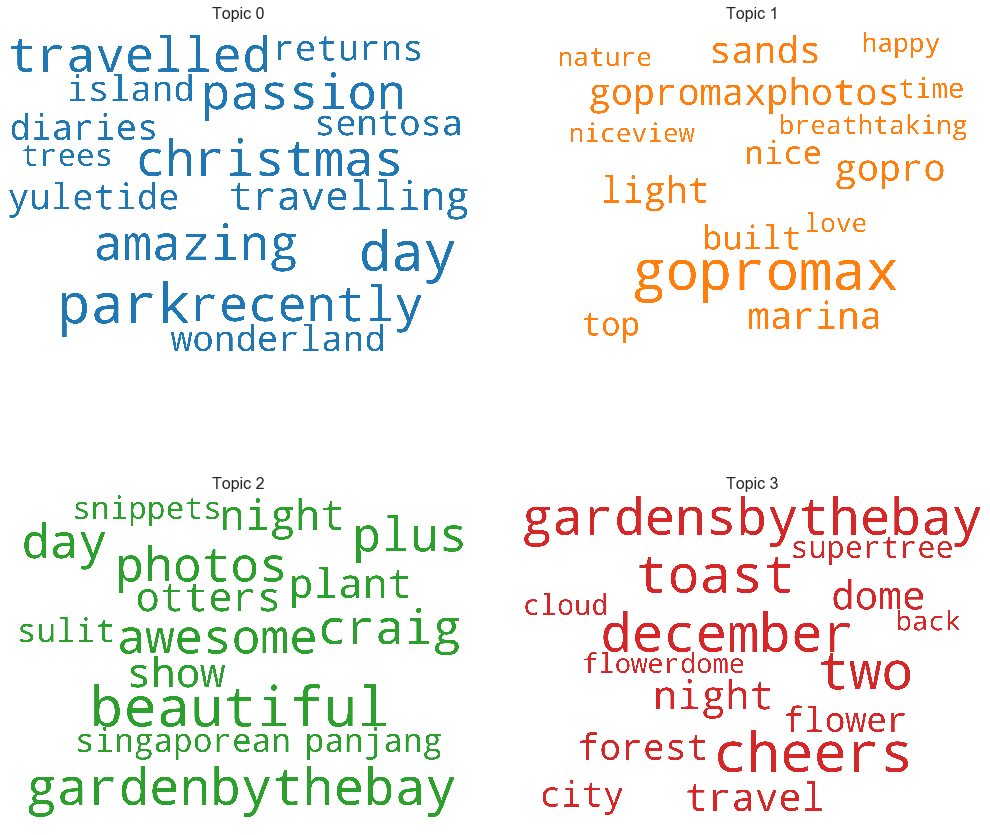

In [47]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_dom.show_topics(num_words=15,formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=20, step=2)

# Show graph
limit=20
start=2 
step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Finding out the dominant topic for each component

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [48]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                clean_words = " ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords,clean_words]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','clean_words']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_dom, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','clean_words', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,clean_words,Text
0,0,3.0,0.9925,"cheers, december, toast, two, gardensbythebay,...",cheers december toast two gardensbythebay nigh...,"[two, cheers, toast, december]"
1,1,2.0,0.9954,"beautiful, gardenbythebay, photos, plus, aweso...",beautiful gardenbythebay photos plus awesome c...,"[last, event, year, never, grows, old, scsm, p..."
2,2,0.0,0.9910,"park, day, christmas, amazing, passion, recent...",park day christmas amazing passion recently tr...,"[diaries, day, sentosa, island]"
3,3,0.0,0.9821,"park, day, christmas, amazing, passion, recent...",park day christmas amazing passion recently tr...,"[day, park]"
4,4,1.0,0.9923,"gopromax, marina, sands, gopromaxphotos, gopro...",gopromax marina sands gopromaxphotos gopro lig...,"[light, gopromax, gopromax, gopromaxvideos, ti..."
5,5,3.0,0.9950,"cheers, december, toast, two, gardensbythebay,...",cheers december toast two gardensbythebay nigh...,"[awesome, free, show, travelinindo, indonesia,..."
6,6,2.0,0.9879,"beautiful, gardenbythebay, photos, plus, aweso...",beautiful gardenbythebay photos plus awesome c...,"[jump, even, shellwanders]"
7,7,3.0,0.9925,"cheers, december, toast, two, gardensbythebay,...",cheers december toast two gardensbythebay nigh...,"[two, cheers, toast, december]"
8,8,2.0,0.9963,"beautiful, gardenbythebay, photos, plus, aweso...",beautiful gardenbythebay photos plus awesome c...,"[recs, friend, headed, asia, december, looking..."
9,9,3.0,0.9925,"cheers, december, toast, two, gardensbythebay,...",cheers december toast two gardensbythebay nigh...,"[two, cheers, toast, december]"


In [49]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [50]:
def topic_sentiment(topic_no,tweets):
    #sentiment score using textblob
    #del tweets['Keywords']
    #del tweets['clean_words']
    tweets = tweets[tweets.Dominant_Topic ==topic_no]
    tweets["Text"]= tweets["Text"].str.join(" ") 
    tweets = tweets[~tweets['Text'].isnull()] 
    tweets['sentiment'] = tweets['Text'].map(lambda text: TextBlob(text).sentiment)
    tweets['polarity'] = tweets['Text'].map(lambda text: TextBlob(text).sentiment.polarity)
    tweets['subjectivity'] = tweets['Text'].map(lambda text: TextBlob(text).sentiment.subjectivity)
    tweets['tweet_len'] = tweets['Text'].astype(str).apply(len)
    tweets['word_count'] = tweets['Text'].apply(lambda x: len(str(x).split()))
    tweets['vaderSentiment']=tweets.Text.apply(sentiment_analyzer_scores)
    tweets['compound'] = tweets['vaderSentiment'].map(lambda text: text['compound'])
    tweets['label'] = tweets['compound'].apply(lambda x: int(0) if x>0 else int(1))
    return tweets

In [51]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

sentiment= topic_sentiment(1.0,df_dominant_topic)

sentiment.label.loc[(sentiment['compound'] > 0)] = 'Positive'
sentiment.label.loc[(sentiment['compound'] == 0)] = 'Neutral'
sentiment.label.loc[(sentiment['compound'] < 0)] = 'Negative'

sentiment['label'].iplot(
    kind='hist',
    bins=20,
    xTitle='Sentiment',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

sentiment['compound'].iplot(
    kind='hist',
    bins=20,
    xTitle='Sentiment',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Positive Sentiment Word Cloud:


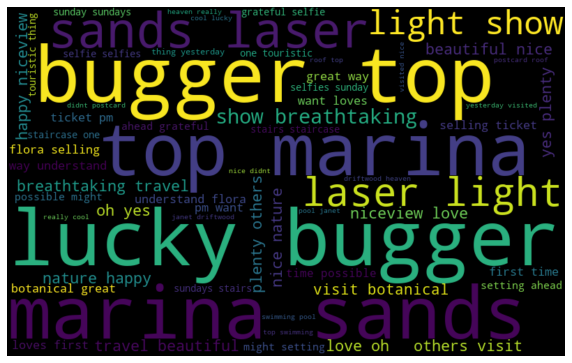

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#print("Negative Sentiment Word Cloud:")
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#negative_words = ' '.join([text for text in sentiment['Text'][sentiment['label'] =='Negative']])
#wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
#plt.figure(figsize=(10, 7))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis('off')
#plt.show()

print("Positive Sentiment Word Cloud:")
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
negative_words = ' '.join([text for text in sentiment['Text'][sentiment['label'] =='Positive']])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()